<h1 style="text-align:center">
Stock Portfolio Forecasting and Optimization on S&P500 Using
Machine Learning and Search Methods</h1>

---

- Constança Fernandes, nº 202205398
- Daniela Osório, nº 202208679
- Inês Amorim, nº 202108108
- Pedro Afonseca, nº 202105394

---

 ## == IMPORTS == 

In [ ]:
%pip install -r ../requirements.txt

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import yfinance as yf
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pickle
from sklearn.preprocessing import RobustScaler

from stock_forecasting.features import *
from stock_forecasting.plots import *
from stock_forecasting.config import PROCESSED_DATA_DIR, RAW_DATA_DIR, MODELS_DIR
from stock_forecasting.modeling.train import train_lstm, predict

---

## 1. Introduction

---

## 2. Dataset Quality Assessment and Exploratory Data Analysis

### 2.1. Raw Dataset (S&P500)

The S&P500 dataset includes historical data (from 2010 to january 2024) on the 500 largest publicly traded companies in the U.S., measured by market capitalization. This was obtained using the library **yfinance**, from Yahoo Finance.

In [3]:
raw_data = pd.read_pickle(RAW_DATA_DIR / "raw.pkl")
raw_data

Ticker                            TYL                                      \
Price                            Open        High         Low       Close   
Date                                                                        
2010-01-04 00:00:00+00:00   20.049999   20.309999   20.049999   20.299999   
2010-01-05 00:00:00+00:00   20.219999   21.360001   20.020000   20.780001   
2010-01-06 00:00:00+00:00   20.799999   21.520000   20.700001   20.770000   
2010-01-07 00:00:00+00:00   20.690001   20.840000   20.350000   20.500000   
2010-01-08 00:00:00+00:00   20.400000   20.740000   20.400000   20.740000   
...                               ...         ...         ...         ...   
2024-01-24 00:00:00+00:00  447.970001  451.709991  439.109985  439.290009   
2024-01-25 00:00:00+00:00  441.600006  441.600006  428.420013  429.250000   
2024-01-26 00:00:00+00:00  429.529999  432.589996  428.320007  430.619995   
2024-01-29 00:00:00+00:00  432.089996  436.410004  430.209991  436.410004   
2024-01-30 00:00:00+00:00  434.269989  437.000000  431.929993  432.059998   

Ticker                                             HAL                        \
Price                      Volume Repaired?       Open       High        Low   
Date                                                                           
2010-01-04 00:00:00+00:00  175300     False  24.386298  24.878470  24.338669   
2010-01-05 00:00:00+00:00  416700     False  24.830845  25.267448  24.600635   
2010-01-06 00:00:00+00:00  274600     False  25.196001  25.870752  25.116618   
2010-01-07 00:00:00+00:00  164100     False  25.648485  25.815188  25.338892   
2010-01-08 00:00:00+00:00   69000     False  26.156536  27.101187  25.791377   
...                           ...       ...        ...        ...        ...   
2024-01-24 00:00:00+00:00  252000     False  35.128161  36.378519  34.931253   
2024-01-25 00:00:00+00:00  230100     False  36.506506  36.673875  35.443208   
2024-01-26 00:00:00+00:00  153500     False  36.299751  37.274441  36.191452   
2024-01-29 00:00:00+00:00  148100     False  36.673877  36.782176  36.201301   
2024-01-30 00:00:00+00:00  136100     False  35.393981  36.437584  34.596508   

Ticker                                ...        MSFT                        \
Price                          Close  ...         Low       Close    Volume   
Date                                  ...                                     
2010-01-04 00:00:00+00:00  24.807026  ...   23.075748   23.347317  38409100   
2010-01-05 00:00:00+00:00  25.124559  ...   23.113469   23.354862  49749600   
2010-01-06 00:00:00+00:00  25.719927  ...   23.022945   23.211535  58182400   
2010-01-07 00:00:00+00:00  25.783434  ...   22.774012   22.970144  50559700   
2010-01-08 00:00:00+00:00  27.085310  ...   22.811729   23.128559  51197400   
...                              ...  ...         ...         ...       ...   
2024-01-24 00:00:00+00:00  36.260376  ...  398.273310  400.371826  24867000   
2024-01-25 00:00:00+00:00  36.427742  ...  400.342004  402.669281  21021200   
2024-01-26 00:00:00+00:00  36.949543  ...  400.242559  401.734406  17803300   
2024-01-29 00:00:00+00:00  36.614803  ...  402.132203  407.492920  24510200   
2024-01-30 00:00:00+00:00  36.240681  ...  404.240727  406.369080  33477600   

Ticker                                      ROK                          \
Price                     Repaired?        Open        High         Low   
Date                                                                      
2010-01-04 00:00:00+00:00     False   34.894110   35.150630   34.454359   
2010-01-05 00:00:00+00:00     False   34.923402   35.047997   34.549614   
2010-01-06 00:00:00+00:00     False   34.703534   35.385146   34.615585   
2010-01-07 00:00:00+00:00     False   35.341168   35.817561   35.033342   
2010-01-08 00:00:00+00:00     False   35.641667   36.286630   35.436448   
...                             ...         ...         ...         ...   
2024-01-24 00:00:0

This dataset has a multilayered header structure, because it includes stock prices from differnet companies and various market sectors. 

**Top Level:** Ticker Symbols for various stock market indices


- **^GSPC:** S&P500 Index. This includes 500 large-cap U.S. stocks and is widely used to represent the U.S. stock market.

**Why choose these indexes?**

Removed:
- GEV, SOLV, AMTM, GEHC: novos demais = não tem dados historicos
- SW: yahoo n tem dados historicos
- BF.B, BRK.B, ZT: n existe no yahoo

**Sub-categories:**

- **Open:** The opening price of the stock for the given day.
- **High:** The highest price during the day.
- **Low:** The lowest price.
- **Close:** The closing price.
- **Volume:** The number of shares traded.

### 2.2 Filter Stocks

We will only keep stocks based on:
- Amount of historical data
- Liquity
- Dollar Liquity
- Mean Annual Return
- Annual Volatility

In [4]:
# Remove stocks without enough historical data
raw_data = delete_recent(raw_data, threshold=0)
raw_data

Ticker                            TYL                                      \
Price                            Open        High         Low       Close   
Date                                                                        
2010-01-04 00:00:00+00:00   20.049999   20.309999   20.049999   20.299999   
2010-01-05 00:00:00+00:00   20.219999   21.360001   20.020000   20.780001   
2010-01-06 00:00:00+00:00   20.799999   21.520000   20.700001   20.770000   
2010-01-07 00:00:00+00:00   20.690001   20.840000   20.350000   20.500000   
2010-01-08 00:00:00+00:00   20.400000   20.740000   20.400000   20.740000   
...                               ...         ...         ...         ...   
2024-01-24 00:00:00+00:00  447.970001  451.709991  439.109985  439.290009   
2024-01-25 00:00:00+00:00  441.600006  441.600006  428.420013  429.250000   
2024-01-26 00:00:00+00:00  429.529999  432.589996  428.320007  430.619995   
2024-01-29 00:00:00+00:00  432.089996  436.410004  430.209991  436.410004   
2024-01-30 00:00:00+00:00  434.269989  437.000000  431.929993  432.059998   

Ticker                                             HAL                        \
Price                      Volume Repaired?       Open       High        Low   
Date                                                                           
2010-01-04 00:00:00+00:00  175300     False  24.386298  24.878470  24.338669   
2010-01-05 00:00:00+00:00  416700     False  24.830845  25.267448  24.600635   
2010-01-06 00:00:00+00:00  274600     False  25.196001  25.870752  25.116618   
2010-01-07 00:00:00+00:00  164100     False  25.648485  25.815188  25.338892   
2010-01-08 00:00:00+00:00   69000     False  26.156536  27.101187  25.791377   
...                           ...       ...        ...        ...        ...   
2024-01-24 00:00:00+00:00  252000     False  35.128161  36.378519  34.931253   
2024-01-25 00:00:00+00:00  230100     False  36.506506  36.673875  35.443208   
2024-01-26 00:00:00+00:00  153500     False  36.299751  37.274441  36.191452   
2024-01-29 00:00:00+00:00  148100     False  36.673877  36.782176  36.201301   
2024-01-30 00:00:00+00:00  136100     False  35.393981  36.437584  34.596508   

Ticker                                ...        MSFT                        \
Price                          Close  ...         Low       Close    Volume   
Date                                  ...                                     
2010-01-04 00:00:00+00:00  24.807026  ...   23.075748   23.347317  38409100   
2010-01-05 00:00:00+00:00  25.124559  ...   23.113469   23.354862  49749600   
2010-01-06 00:00:00+00:00  25.719927  ...   23.022945   23.211535  58182400   
2010-01-07 00:00:00+00:00  25.783434  ...   22.774012   22.970144  50559700   
2010-01-08 00:00:00+00:00  27.085310  ...   22.811729   23.128559  51197400   
...                              ...  ...         ...         ...       ...   
2024-01-24 00:00:00+00:00  36.260376  ...  398.273310  400.371826  24867000   
2024-01-25 00:00:00+00:00  36.427742  ...  400.342004  402.669281  21021200   
2024-01-26 00:00:00+00:00  36.949543  ...  400.242559  401.734406  17803300   
2024-01-29 00:00:00+00:00  36.614803  ...  402.132203  407.492920  24510200   
2024-01-30 00:00:00+00:00  36.240681  ...  404.240727  406.369080  33477600   

Ticker                                      ROK                          \
Price                     Repaired?        Open        High         Low   
Date                                                                      
2010-01-04 00:00:00+00:00     False   34.894110   35.150630   34.454359   
2010-01-05 00:00:00+00:00     False   34.923402   35.047997   34.549614   
2010-01-06 00:00:00+00:00     False   34.703534   35.385146   34.615585   
2010-01-07 00:00:00+00:00     False   35.341168   35.817561   35.033342   
2010-01-08 00:00:00+00:00     False   35.641667   36.286630   35.436448   
...                             ...         ...         ...         ...   
2024-01-24 00:00:0

/home/inesamorim46/3ano1sem/labiacd/stocks-prediction-labia/stock_forecasting/features.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[(ticker, "Dollar_Volume")] = data[(ticker, "Close")] * data[(ticker, "Volume")]
/home/inesamorim46/3ano1sem/labiacd/stocks-prediction-labia/stock_forecasting/features.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[(ticker, "Dollar_Volume")] = data[(ticker, "Close")] * data[(ticker, "Volume")]
/home/inesamorim46/3ano1sem/labiacd/stocks-prediction-labia/stock_forecasting/featur

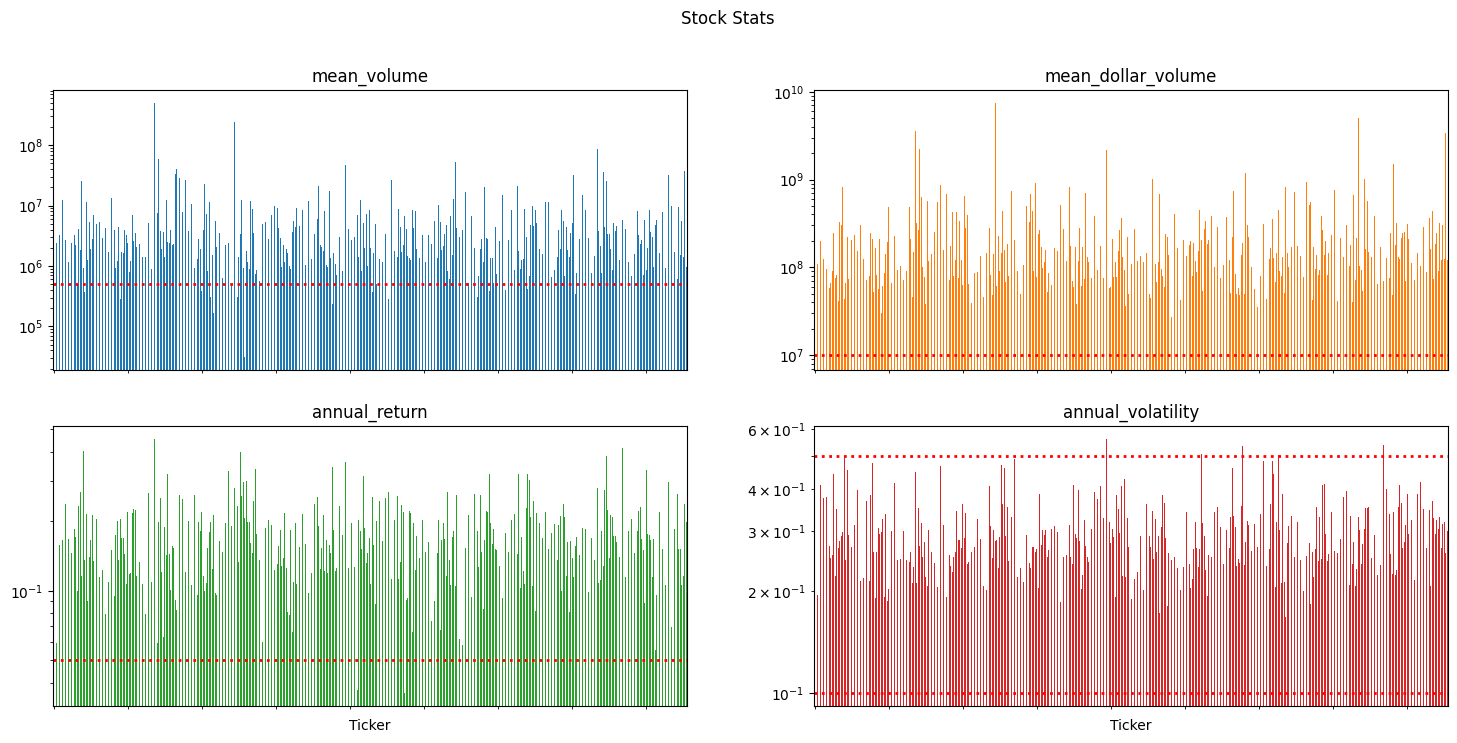

In [5]:
stock_stats = calculate_stock_stats(raw_data)
plot_stock_stats(stock_stats)

In [6]:
filtered_data, removed_stocks = filter_stocks(raw_data, stock_stats)
print(f"Stocks removed ({len(removed_stocks)}): {removed_stocks.to_list()}")
filtered_data

Stocks removed (37): ['TYL', 'BLDR', 'FRT', 'ESS', 'SNA', 'NDSN', 'ZBRA', 'HUBB', 'MTD', 'STE', 'AZO', 'NVR', 'FICO', 'AMD', 'ANSS', 'VTRS', 'WST', 'ROP', 'TFX', 'POOL', 'TDY', 'ERIE', 'WBA', 'WBD', 'NFLX', 'APA', 'MKTX', 'FDS', 'FSLR', 'MPWR', 'JKHY', 'IEX', 'FCX', 'TDG', 'PCG', 'EG', 'SMCI']


Ticker                           HAL                                   \
Price                           Open       High        Low      Close   
Date                                                                    
2010-01-04 00:00:00+00:00  24.386298  24.878470  24.338669  24.807026   
2010-01-05 00:00:00+00:00  24.830845  25.267448  24.600635  25.124559   
2010-01-06 00:00:00+00:00  25.196001  25.870752  25.116618  25.719927   
2010-01-07 00:00:00+00:00  25.648485  25.815188  25.338892  25.783434   
2010-01-08 00:00:00+00:00  26.156536  27.101187  25.791377  27.085310   
...                              ...        ...        ...        ...   
2024-01-24 00:00:00+00:00  35.128161  36.378519  34.931253  36.260376   
2024-01-25 00:00:00+00:00  36.506506  36.673875  35.443208  36.427742   
2024-01-26 00:00:00+00:00  36.299751  37.274441  36.191452  36.949543   
2024-01-29 00:00:00+00:00  36.673877  36.782176  36.201301  36.614803   
2024-01-30 00:00:00+00:00  35.393981  36.437584  34.596508  36.240681   

Ticker                                                 K             \
Price                        Volume Repaired?       Open       High   
Date                                                                  
2010-01-04 00:00:00+00:00  11571600     False  30.855259  31.005742   
2010-01-05 00:00:00+00:00  18989700     False  30.560060  30.664242   
2010-01-06 00:00:00+00:00  15720800     False  30.571646  30.756858   
2010-01-07 00:00:00+00:00   8993100     False  30.548492  30.976796   
2010-01-08 00:00:00+00:00  23014600     False  30.849461  30.895765   
...                             ...       ...        ...        ...   
2024-01-24 00:00:00+00:00  14417400     False  52.940986  52.979942   
2024-01-25 00:00:00+00:00  11492100     False  52.288473  53.330541   
2024-01-26 00:00:00+00:00   8835500     False  53.359764  53.651932   
2024-01-29 00:00:00+00:00   5857600     False  53.359760  53.466889   
2024-01-30 00:00:00+00:00  18937100     False  53.311068  53.856448   

Ticker                                           ...        MSFT              \
Price                            Low      Close  ...         Low       Close   
Date                                             ...                           
2010-01-04 00:00:00+00:00  30.426955  30.577438  ...   23.075748   23.347317   
2010-01-05 00:00:00+00:00  30.415363  30.646879  ...   23.113469   23.354862   
2010-01-06 00:00:00+00:00  30.444312  30.652676  ...   23.022945   23.211535   
2010-01-07 00:00:00+00:00  30.502188  30.953644  ...   22.774012   22.970144   
2010-01-08 00:00:00+00:00  30.675825  30.895765  ...   22.811729   23.128559   
...                              ...        ...  ...         ...         ...   
2024-01-24 00:00:00+00:00  52.025521  52.074219  ...  398.273310  400.371826   
2024-01-25 00:00:00+00:00  52.113171  53.203938  ...  400.342004  402.669281   
2024-01-26 00:00:00+00:00  53.233156  53.311069  ...  400.242559  401.734406   
2024-01-29 00:00:00+00:00  53.116286  53.359760  ...  402.132203  407.492920   
2024-01-30 00:00:00+00:00  53.077331  53.846710  ...  404.240727  406.369080   

Ticker                                                ROK              \
Price                        Volume Repaired?        Open        High   
Date                                                                    
2010-01-04 00:00:00+00:00  38409100     False   34.894110   35.150630   
2010-01-05 00:00:00+00:00  49749600     False   34.923402   35.047997   
2010-01-06 00:00:00+00:00  58182400     False   34.703534   35.385146   
2010-01-07 00:00:00+00:00  50559700     False   35.341168   35.817561   
2010-01-08 00:00:00+00:00  51197400     False   35.641667   36.286630   
...                             ...       ...         ...         ...   
2024-01-24 00:00:00+00:00  24867000     False  301.659200  301.659200   
2024-01-25 00:00:00+00:00  21021200     False  297.722821  301.345090   
2024-01-26 00:00:00+00:00  17803300     False  300.147519 

In [ ]:
filtered_data.to_pickle(PROCESSED_DATA_DIR / "filtered.pkl")

In [18]:
filtered_data = pd.read_pickle(PROCESSED_DATA_DIR / "filtered.pkl")

In [17]:
# Dont explode memory
del raw_data, removed_stocks, stock_stats

### 2.3 Feature enginnering

New features:

- **Close_Ratio_X:** measures how the closing price of a stock compares to its rolling average over the last X days. A value gretaer than 1 means that the stock's closing price is above its rolling average, indicating it is trading higher that its recent trend.
The **Close Ratio** for a given horizon \( X \) is defined as:

$$ \text{Close\_Ratio}_X = \frac{\text{Close Price}}{\text{Rolling Average}_X} $$

Where:
$$ \text{Rolling Average}_X = \frac{1}{X} \sum_{i=t-X+1}^{t} \text{Close Price}_i $$

- **Trend_X:** represents the cumulative percentage change in the stock price over the last X days. Positive values suggest an upward trend over the x-day period (cumulative gain).

$$ \text{Trend}_{t,h} = \sum_{i=t-h+1}^t \text{Target}_i $$

- **Relative Strength Index (RSI):** momentum oscillator that measures the **speed and change of price movements**. Its typically used to **identify overbought or oversold conditions** in a market and is one of the **most widely** used technical indicators in financial markets, particularly in stock trading. 

$$ \text{RSI}_t = 100 - \frac{100}{1 + \frac{\text{Average Gain}}{\text{Average Loss}}} $$

- **Exponential Moving Average (EMA):** is a type of weighted moving average that gives **more weight to recent data points**, making it **more responsive to recent price changes** compared to the simple moving average (SMA). It is commonly used in technical analysis to **identify trends, smooth out price fluctuations, and generate buy or sell signals**. The EMA is particularly useful in markets with **volatile price movements**, as it emphasizes recent price action while still accounting for historical.data. The EMA with a smoothing factor $$ \alpha = \frac{2}{\text{span} + 1} $$ is :

$$ \text{EMA}_t = \alpha \cdot \text{Close}_t + (1 - \alpha) \cdot \text{EMA}_{t-1} $$

Our target is the daily percentage change in the closing price:

$$ \text{Target}_t = \frac{\text{Close}_t - \text{Close}_{t-1}}{\text{Close}_{t-1}} $$

In [7]:
processed = extract_features(filtered_data)
processed

/home/inesamorim46/3ano1sem/labiacd/stocks-prediction-labia/stock_forecasting/features.py:147: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_all[(ticker, "Target")] = data_all[(ticker, "Close")].pct_change(fill_method=None)
/home/inesamorim46/3ano1sem/labiacd/stocks-prediction-labia/stock_forecasting/features.py:147: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_all[(ticker, "Target")] = data_all[(ticker, "Close")].pct_change(fill_method=None)
/home/inesamorim46/3ano1sem/labiacd/stocks-prediction-labia/stock_forecastin

Ticker                              HAL                                    \
Price                     Close_Ratio_2   Trend_2 Close_Ratio_5   Trend_5   
Date                                                                        
2010-01-04 00:00:00+00:00           NaN       NaN           NaN       NaN   
2010-01-05 00:00:00+00:00      1.006359       NaN           NaN       NaN   
2010-01-06 00:00:00+00:00      1.011710       NaN           NaN       NaN   
2010-01-07 00:00:00+00:00      1.001233  0.036497           NaN       NaN   
2010-01-08 00:00:00+00:00      1.024625  0.026166      1.053737       NaN   
...                                 ...       ...           ...       ...   
2024-01-24 00:00:00+00:00      1.021212  0.038810      1.059307  0.052673   
2024-01-25 00:00:00+00:00      1.002303  0.068611      1.042077  0.104073   
2024-01-26 00:00:00+00:00      1.007111  0.047959      1.036225  0.106583   
2024-01-29 00:00:00+00:00      0.995450  0.018940      1.011422  0.101093   
2024-01-30 00:00:00+00:00      0.994865  0.005265      0.992933  0.078492   

Ticker                                                                        \
Price                     Close_Ratio_60  Trend_60 Close_Ratio_250 Trend_250   
Date                                                                           
2010-01-04 00:00:00+00:00            NaN       NaN             NaN       NaN   
2010-01-05 00:00:00+00:00            NaN       NaN             NaN       NaN   
2010-01-06 00:00:00+00:00            NaN       NaN             NaN       NaN   
2010-01-07 00:00:00+00:00            NaN       NaN             NaN       NaN   
2010-01-08 00:00:00+00:00            NaN       NaN             NaN       NaN   
...                                  ...       ...             ...       ...   
2024-01-24 00:00:00+00:00       1.006141 -0.122418        1.025281 -0.039847   
2024-01-25 00:00:00+00:00       1.011902 -0.056044        1.030389 -0.001273   
2024-01-26 00:00:00+00:00       1.027201 -0.055231        1.045413 -0.020890   
2024-01-29 00:00:00+00:00       1.018814 -0.036361        1.036223  0.005142   
2024-01-30 00:00:00+00:00       1.009527 -0.043391        1.026056  0.000525   

Ticker                                           ...       IPG       CMI  \
Price                            EMA        RSI  ...    Target    Target   
Date                                             ...                       
2010-01-04 00:00:00+00:00  24.807026        NaN  ...       NaN       NaN   
2010-01-05 00:00:00+00:00  24.855877        NaN  ... -0.010624  0.023647   
2010-01-06 00:00:00+00:00  24.988808        NaN  ...  0.000000  0.009157   
2010-01-07 00:00:00+00:00  25.111058        NaN  ... -0.025504  0.050732   
2010-01-08 00:00:00+00:00  25.414789        NaN  ...  0.001378  0.053386   
...                              ...        ...  ...       ...       ...   
2024-01-24 00:00:00+00:00  34.351221  56.022427  ... -0.001549 -0.001694   
2024-01-25 00:00:00+00:00  34.670686  63.664102  ...  0.021409  0.012935   
2024-01-26 00:00:00+00:00  35.021279  73.667689  ...  0.001823  0.007452   
2024-01-29 00:00:00+00:00  35.266437  74.840789  ...  0.012735  0.000956   
2024-01-30 00:00:00+00:00  35.416321  70.030582  ... -0.003892  0.008054   

Ticker                           EA      MSCI      SCHW       DLR        DD  \
Price                        Target    Target    Target    Target    Target   
Date                                                                          
2010-01-04 00:00:00+00:00       NaN       NaN       NaN       NaN       NaN   
2010-01-05 00:00:00+00:00  0.028099  0.003753 -0.003034  0.006580  0.044551   
2010-01-06 00:00:00+00:00 -0.025723 -0.027103 -0.018255 -0.013471  0.017717   
2010-01-07 00:00:00+00:00 -0.007701  0.068844 -0.003616  0.008835  0.000645   
2010-01-08 00:00:00+00:00  0.019956  0.033553 -0.006740  0.011147  0.003543   
...                             ...       ...       ...       ...       ...   
2024-01-24 00:00:00+00:0

In [8]:
processed.dropna(inplace=True)
processed

Ticker                              HAL                                    \
Price                     Close_Ratio_2   Trend_2 Close_Ratio_5   Trend_5   
Date                                                                        
2010-12-31 00:00:00+00:00      0.997801  0.034612      1.010544  0.015206   
2011-01-03 00:00:00+00:00      0.999019  0.003476      1.004139  0.013044   
2011-01-04 00:00:00+00:00      0.985056 -0.006349      0.974955  0.022493   
2011-01-05 00:00:00+00:00      0.998354 -0.031407      0.977872 -0.001184   
2011-01-06 00:00:00+00:00      0.984544 -0.032735      0.961412 -0.031219   
...                                 ...       ...           ...       ...   
2024-01-24 00:00:00+00:00      1.021212  0.038810      1.059307  0.052673   
2024-01-25 00:00:00+00:00      1.002303  0.068611      1.042077  0.104073   
2024-01-26 00:00:00+00:00      1.007111  0.047959      1.036225  0.106583   
2024-01-29 00:00:00+00:00      0.995450  0.018940      1.011422  0.101093   
2024-01-30 00:00:00+00:00      0.994865  0.005265      0.992933  0.078492   

Ticker                                                                        \
Price                     Close_Ratio_60  Trend_60 Close_Ratio_250 Trend_250   
Date                                                                           
2010-12-31 00:00:00+00:00       1.111599  0.205692        1.306845  0.375537   
2011-01-03 00:00:00+00:00       1.105802  0.203945        1.302827  0.358348   
2011-01-04 00:00:00+00:00       1.070865  0.212289        1.263257  0.332691   
2011-01-05 00:00:00+00:00       1.064969  0.149825        1.258187  0.300775   
2011-01-06 00:00:00+00:00       1.030942  0.151433        1.219133  0.246995   
...                                  ...       ...             ...       ...   
2024-01-24 00:00:00+00:00       1.006141 -0.122418        1.025281 -0.039847   
2024-01-25 00:00:00+00:00       1.011902 -0.056044        1.030389 -0.001273   
2024-01-26 00:00:00+00:00       1.027201 -0.055231        1.045413 -0.020890   
2024-01-29 00:00:00+00:00       1.018814 -0.036361        1.036223  0.005142   
2024-01-30 00:00:00+00:00       1.009527 -0.043391        1.026056  0.000525   

Ticker                                           ...       IPG       CMI  \
Price                            EMA        RSI  ...    Target    Target   
Date                                             ...                       
2010-12-31 00:00:00+00:00  32.405042  47.505236  ... -0.000941 -0.001362   
2011-01-03 00:00:00+00:00  32.456154  62.631046  ...  0.013183  0.015816   
2011-01-04 00:00:00+00:00  32.351091  42.035479  ... -0.026951 -0.001342   
2011-01-05 00:00:00+00:00  32.246122  44.496629  ...  0.014326  0.012455   
2011-01-06 00:00:00+00:00  32.008987  31.477881  ... -0.000941 -0.025046   
...                              ...        ...  ...       ...       ...   
2024-01-24 00:00:00+00:00  34.351221  56.022427  ... -0.001549 -0.001694   
2024-01-25 00:00:00+00:00  34.670686  63.664102  ...  0.021409  0.012935   
2024-01-26 00:00:00+00:00  35.021279  73.667689  ...  0.001823  0.007452   
2024-01-29 00:00:00+00:00  35.266437  74.840789  ...  0.012735  0.000956   
2024-01-30 00:00:00+00:00  35.416321  70.030582  ... -0.003892  0.008054   

Ticker                           EA      MSCI      SCHW       DLR        DD  \
Price                        Target    Target    Target    Target    Target   
Date                                                                          
2010-12-31 00:00:00+00:00 -0.014440 -0.011418 -0.002332  0.001360 -0.003212   
2011-01-03 00:00:00+00:00  0.000000  0.012577  0.022794  0.011060  0.024605   
2011-01-04 00:00:00+00:00  0.000000 -0.016477 -0.016000 -0.021685 -0.006861   
2011-01-05 00:00:00+00:00 -0.006105  0.013403  0.049942  0.004708 -0.001727   
2011-01-06 00:00:00+00:00 -0.003071 -0.007630 -0.006084  0.013666  0.019031   
...                             ...       ...       ...       ...       ...   
2024-01-24 00:00:00+00:0

In [21]:
processed.to_pickle(PROCESSED_DATA_DIR / "extra_features.pkl")

In [3]:
processed = pd.read_pickle(PROCESSED_DATA_DIR / "extra_features.pkl")

### 2.4 Feature analysis

In [ ]:
STOCK = "AMZN"

# Get features for one stock
df = processed.xs(STOCK, level=0, axis=1)
df.loc[:, "Next_Target"] = df["Target"].shift(-1)
df = df.reindex([
    "Close_Ratio_2", "Close_Ratio_5", "Close_Ratio_60", "Close_Ratio_250",
    "Trend_2", "Trend_5", "Trend_60", "Trend_250",
    "EMA", "RSI",
    "Target", "Next_Target",
    ], axis=1)
df.dropna(inplace=True)
df

/tmp/ipykernel_38196/69195278.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "Next_Target"] = df["Target"].shift(-1)


Price                      Close_Ratio_2  Close_Ratio_5  Close_Ratio_60  \
Date                                                                      
2010-12-31 00:00:00+00:00       0.992419       0.989718        1.056378   
2011-01-03 00:00:00+00:00       1.011586       1.010610        1.078197   
2011-01-04 00:00:00+00:00       1.002140       1.010597        1.079718   
2011-01-05 00:00:00+00:00       1.006471       1.019252        1.090136   
2011-01-06 00:00:00+00:00       0.995821       1.007360        1.077992   
...                                  ...            ...             ...   
2024-01-23 00:00:00+00:00       1.003990       1.011344        1.063903   
2024-01-24 00:00:00+00:00       1.002717       1.010096        1.065184   
2024-01-25 00:00:00+00:00       1.002797       1.010234        1.067534   
2024-01-26 00:00:00+00:00       1.004324       1.014097        1.073607   
2024-01-29 00:00:00+00:00       1.006680       1.019317        1.084610   

Price                      Close_Ratio_250   Trend_2   Trend_5  Trend_60  \
Date                                                                       
2010-12-31 00:00:00+00:00         1.293297  0.009209 -0.010765  0.138285   
2011-01-03 00:00:00+00:00         1.321644 -0.018429 -0.014068  0.157240   
2011-01-04 00:00:00+00:00         1.325219  0.008397  0.011841  0.175086   
2011-01-05 00:00:00+00:00         1.340412  0.027733  0.021894  0.183982   
2011-01-06 00:00:00+00:00         1.327146  0.017315  0.022330  0.213209   
...                                    ...       ...       ...       ...   
2024-01-23 00:00:00+00:00         1.248649  0.008382  0.001271  0.195015   
2024-01-24 00:00:00+00:00         1.253057  0.004406  0.018725  0.258798   
2024-01-25 00:00:00+00:00         1.257734  0.013459  0.033640  0.279239   
2024-01-26 00:00:00+00:00         1.266360  0.011058  0.027451  0.216520   
2024-01-29 00:00:00+00:00         1.280916  0.014294  0.024149  0.186298   

Price                      Trend_250    Target  Next_Target  
Date                                                         
2010-12-31 00:00:00+00:00   0.364144 -0.015048     0.023444  
2011-01-03 00:00:00+00:00   0.343197  0.023444     0.004288  
2011-01-04 00:00:00+00:00   0.384757  0.004288     0.013026  
2011-01-05 00:00:00+00:00   0.406058  0.013026    -0.008324  
2011-01-06 00:00:00+00:00   0.392008 -0.008324    -0.001991  
...                              ...       ...          ...  
2024-01-23 00:00:00+00:00   0.512794  0.008011     0.005448  
2024-01-24 00:00:00+00:00   0.533111  0.005448     0.005610  
2024-01-25 00:00:00+00:00   0.529630  0.005610     0.008685  
2024-01-26 00:00:00+00:00   0.514248  0.008685     0.013449  
2024-01-29 00:00:00+00:00   0.492495  0.013449    -0.014015  

[3290 rows x 10 columns]

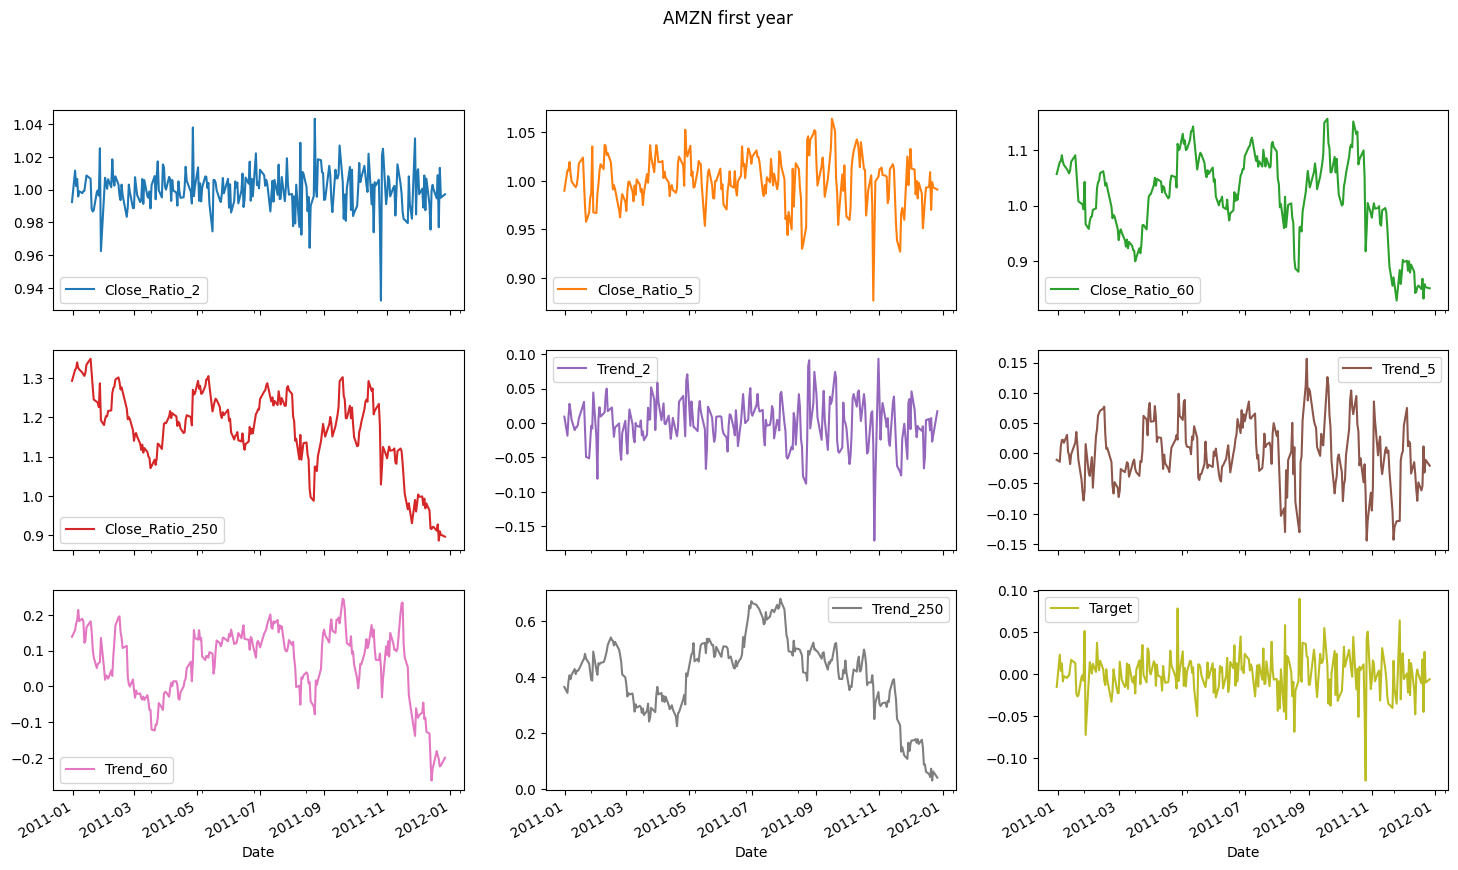

In [38]:
_ = df.drop("Next_Target", axis=1)[:250*1].plot(subplots=True, layout=(3, 3), figsize=(18, 10), title=f"{STOCK} first year")

Text(0.5, 1.0, 'AMZN feature correlation')

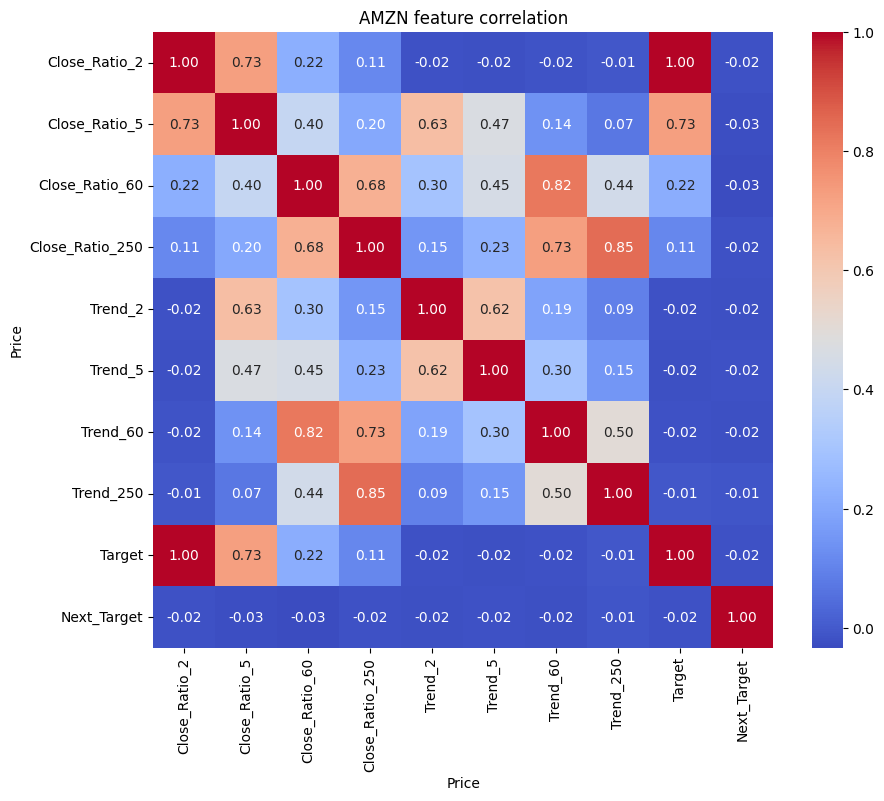

In [39]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title(f"{STOCK} feature correlation")

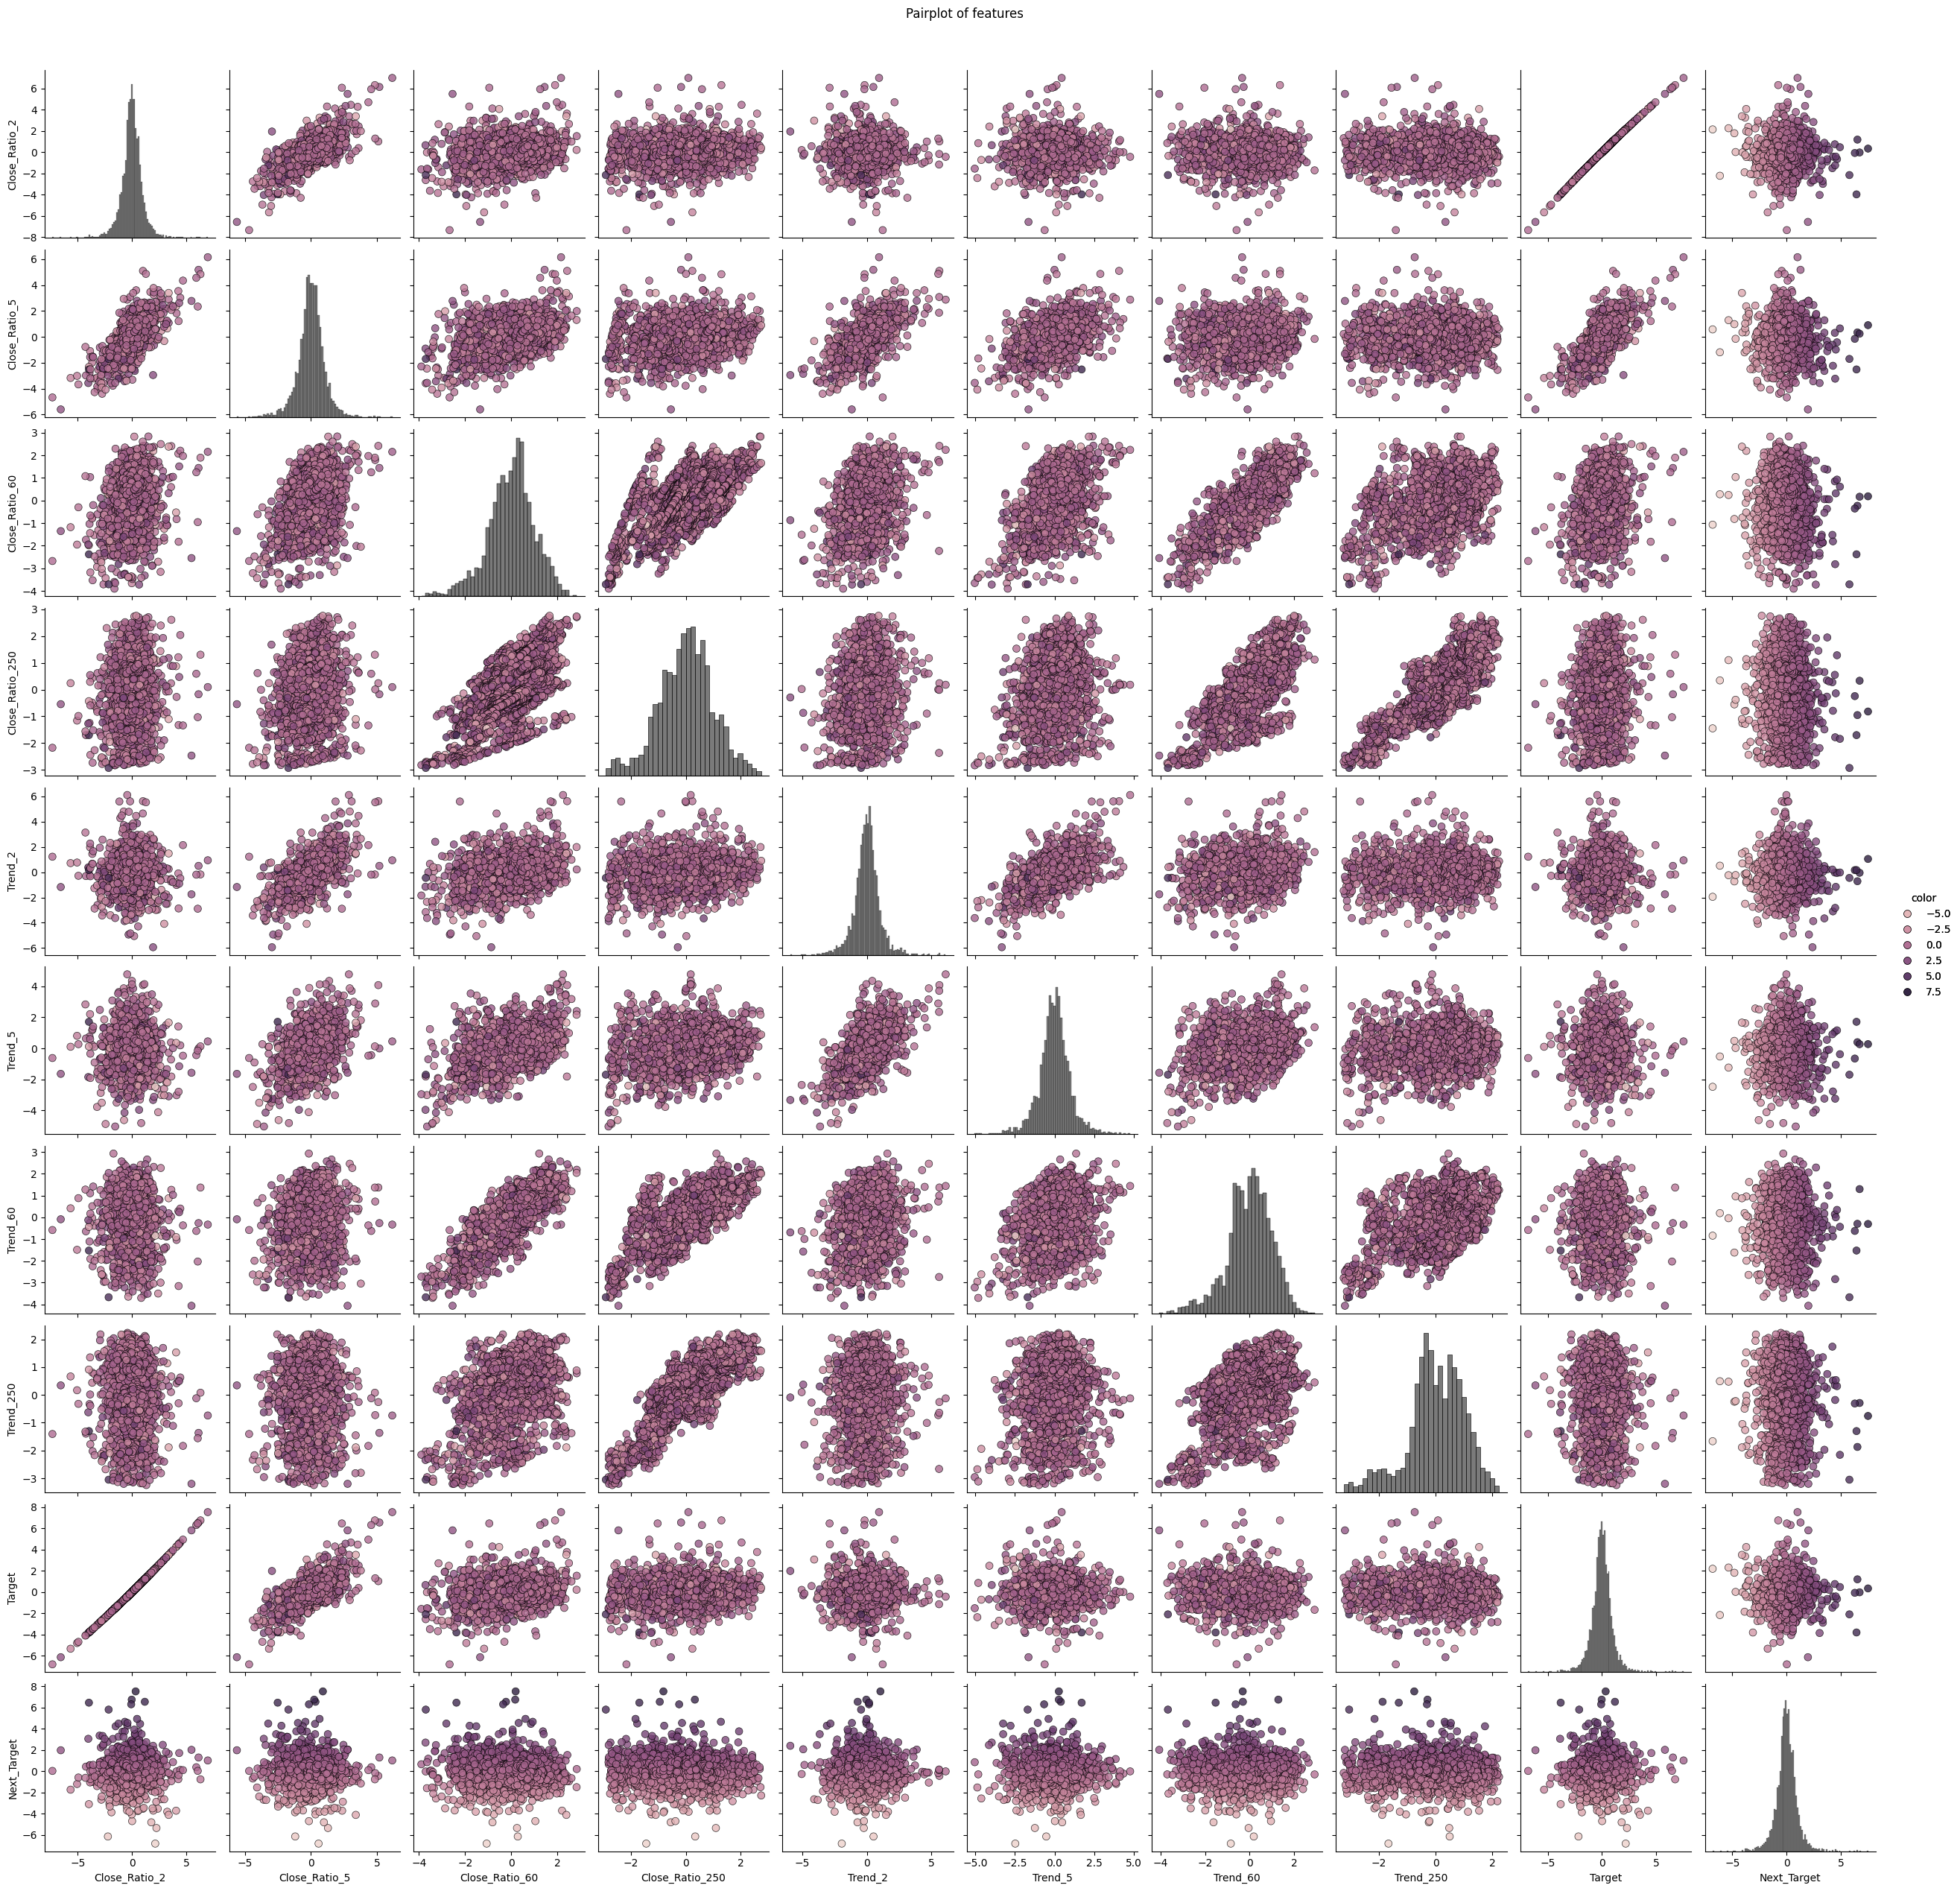

In [ ]:
pairplot(df)

### 2.5 Feature Selection

We employ Recursive Feature Elimination (RFE) to select the most important features.

RFE is a feature selection method that iteratively eliminates the least important features based on model performance until the target number of features is reached. In this case, we use Lasso regression with alpha=0.1 to rank the features by importance, remove the least significant ones, and repeat the process.

In [ ]:
best_features, feature_selection_pipe = feature_selection(processed, min_features_to_select=100, step=100, verbose=True)
print("Old number of features:", len(processed.columns))
print("New number of features:", len(best_features.columns))

In [ ]:
best_features.to_pickle(PROCESSED_DATA_DIR / "final.pkl")

---

## 3. Application of ML algorithms for Stock Price Predicition

Our main objective is to predict which tickers will be the best investments for January 2024. To achieve this, we will make predictions in **5-day intervals**, forecasting the price variations for each ticker. By repeating this process, we will build a prediction for the entire month of January, which will help us identify the most promising stocks to invest in based on their performance over these 5-day periods. This approach ensures that we make informed, short-term investment decisions throughout the month.

## 3.1 LSTM

In [ ]:
# Load data
df = pd.read_pickle(PROCESSED_DATA_DIR / "final.pkl")
df

Ticker                              HAL                                    \
Price                     Close_Ratio_2   Trend_2 Close_Ratio_5   Trend_5   
Date                                                                        
2010-12-31 00:00:00+00:00      0.997801  0.034612      1.010544  0.015206   
2011-01-03 00:00:00+00:00      0.999019  0.003476      1.004139  0.013044   
2011-01-04 00:00:00+00:00      0.985056 -0.006349      0.974955  0.022493   
2011-01-05 00:00:00+00:00      0.998354 -0.031407      0.977872 -0.001184   
2011-01-06 00:00:00+00:00      0.984544 -0.032735      0.961412 -0.031219   
...                                 ...       ...           ...       ...   
2024-01-24 00:00:00+00:00      1.021212  0.038810      1.059307  0.052673   
2024-01-25 00:00:00+00:00      1.002303  0.068611      1.042077  0.104073   
2024-01-26 00:00:00+00:00      1.007111  0.047959      1.036225  0.106583   
2024-01-29 00:00:00+00:00      0.995450  0.018940      1.011422  0.101093   
2024-01-30 00:00:00+00:00      0.994865  0.005265      0.992933  0.078492   

Ticker                                                                        \
Price                     Close_Ratio_60  Trend_60 Close_Ratio_250 Trend_250   
Date                                                                           
2010-12-31 00:00:00+00:00       1.111599  0.205692        1.306845  0.375537   
2011-01-03 00:00:00+00:00       1.105802  0.203945        1.302827  0.358348   
2011-01-04 00:00:00+00:00       1.070865  0.212289        1.263257  0.332691   
2011-01-05 00:00:00+00:00       1.064969  0.149825        1.258187  0.300775   
2011-01-06 00:00:00+00:00       1.030942  0.151433        1.219133  0.246995   
...                                  ...       ...             ...       ...   
2024-01-24 00:00:00+00:00       1.006141 -0.122418        1.025281 -0.039847   
2024-01-25 00:00:00+00:00       1.011902 -0.056044        1.030389 -0.001273   
2024-01-26 00:00:00+00:00       1.027201 -0.055231        1.045413 -0.020890   
2024-01-29 00:00:00+00:00       1.018814 -0.036361        1.036223  0.005142   
2024-01-30 00:00:00+00:00       1.009527 -0.043391        1.026056  0.000525   

Ticker                                K            ...       IPG       CMI  \
Price                     Close_Ratio_2   Trend_2  ...    Target    Target   
Date                                               ...                       
2010-12-31 00:00:00+00:00      0.999609 -0.000586  ... -0.000941 -0.001362   
2011-01-03 00:00:00+00:00      0.998038 -0.000587  ...  0.013183  0.015816   
2011-01-04 00:00:00+00:00      1.004013 -0.004698  ... -0.026951 -0.001342   
2011-01-05 00:00:00+00:00      0.997851  0.004143  ...  0.014326  0.012455   
2011-01-06 00:00:00+00:00      0.998529  0.003769  ... -0.000941 -0.025046   
...                                 ...       ...  ...       ...       ...   
2024-01-24 00:00:00+00:00      0.990919  0.009735  ... -0.001549 -0.001694   
2024-01-25 00:00:00+00:00      1.010731 -0.002329  ...  0.021409  0.012935   
2024-01-26 00:00:00+00:00      1.001006  0.003696  ...  0.001823  0.007452   
2024-01-29 00:00:00+00:00      1.000456  0.023708  ...  0.012735  0.000956   
2024-01-30 00:00:00+00:00      1.004542  0.002927  ... -0.003892  0.008054   

Ticker                           EA      MSCI      SCHW       DLR        DD  \
Price                        Target    Target    Target    Target    Target   
Date                                                                          
2010-12-31 00:00:00+00:00 -0.014440 -0.011418 -0.002332  0.001360 -0.003212   
2011-01-03 00:00:00+00:00  0.000000  0.012577  0.022794  0.011060  0.024605   
2011-01-04 00:00:00+00:00  0.000000 -0.016477 -0.016000 -0.021685 -0.006861   
2011-01-05 00:00:00+00:00 -0.006105  0.013403  0.049942  0.004708 -0.001727   
2011-01-06 00:00:00+00:00 -0.003071 -0.007630 -0.006084  0.013666  0.019031   
...                             ...       ...       ...       ...       ...

In [ ]:
# Normalize data
columns = df.columns
scaler = RobustScaler()
scaler.set_output(transform="pandas")
df = scaler.fit_transform(df)
df.columns = columns

In [ ]:
# Train lstm
train_size = int(len(df) * 0.8)
history, window = train_lstm(df.iloc[:train_size], df.iloc[train_size:], epochs=1)

W0000 00:00:1732982862.075405    3497 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


82/82 ━━━━━━━━━━━━━━━━━━━━ 1097s 3s/step - .GSPC_loss: 2.3992 - .GSPC_mae: 0.6857 - AAPL_loss: 2.5982 - AAPL_mae: 0.6918 - ABT_loss: 1.9891 - ABT_mae: 0.6381 - ACGL_loss: 1.4015 - ACGL_mae: 0.5448 - ACN_loss: 2.4600 - ACN_mae: 0.6958 - ADBE_loss: 3.0881 - ADBE_mae: 0.7586 - ADI_loss: 2.4753 - ADI_mae: 0.6854 - ADM_loss: 2.4772 - ADM_mae: 0.6712 - ADP_loss: 2.5067 - ADP_mae: 0.6921 - ADSK_loss: 3.2624 - ADSK_mae: 0.7947 - AEE_loss: 2.7772 - AEE_mae: 0.7422 - AEP_loss: 2.2456 - AEP_mae: 0.6701 - AES_loss: 2.5048 - AES_mae: 0.6301 - AFL_loss: 2.2291 - AFL_mae: 0.6754 - AIG_loss: 3.4798 - AIG_mae: 0.8084 - AIZ_loss: 2.0778 - AIZ_mae: 0.6520 - AJG_loss: 3.2193 - AJG_mae: 0.7187 - AKAM_loss: 2.2603 - AKAM_mae: 0.6260 - ALB_loss: 2.1198 - ALB_mae: 0.6629 - ALGN_loss: 2.4911 - ALGN_mae: 0.7173 - ALL_loss: 2.7679 - ALL_mae: 0.6883 - AMAT_loss: 2.3094 - AMAT_mae: 0.6746 - AME_loss: 2.3767 - AME_mae: 0.6867 - AMGN_loss: 2.3347 - AMGN_mae: 0.6818 - AMP_loss: 2.7659 - AMP_mae: 0.7466 - AMT_loss: 2.

In [ ]:
# Save the model
with open(MODELS_DIR / 'lstm.pkl', 'wb') as f:
    pickle.dump(history, f)
with open(MODELS_DIR / 'window.pkl', 'wb') as f:
    pickle.dump(window, f)

In [ ]:
# Load the model
with open(MODELS_DIR / 'lstm.pkl', "rb") as file_pi:
    history = pickle.load(file_pi)
with open(MODELS_DIR / 'window.pkl', "rb") as file_pi:
    window = pickle.load(file_pi)

(32, 5)
(32, 5)
(32, 5)


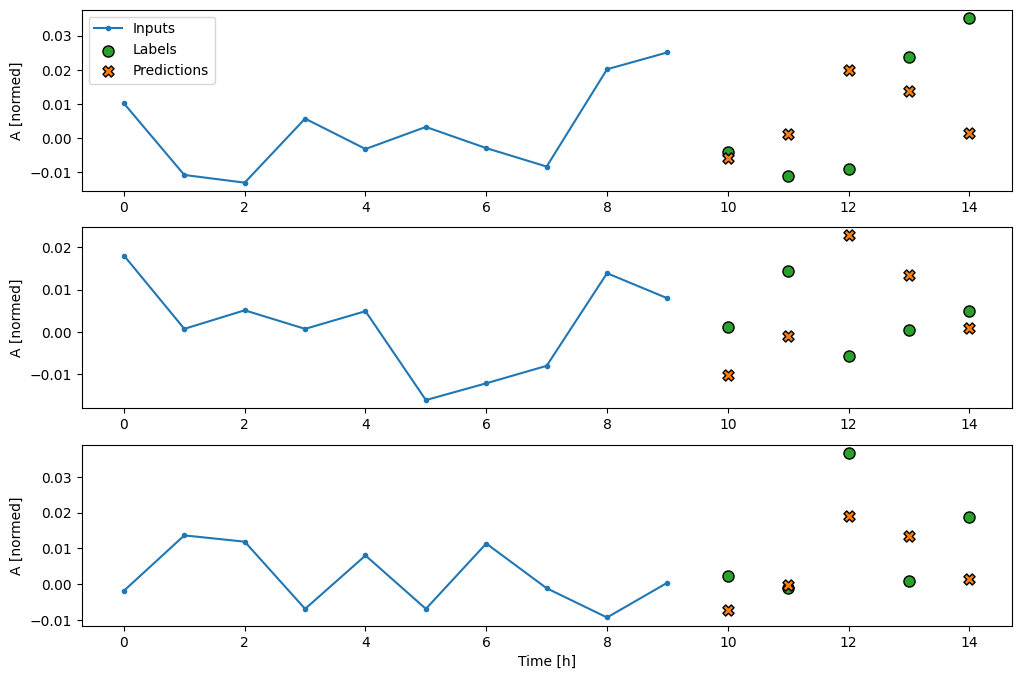

In [16]:
# Plot some predictions
window.plot(model=history.model, plot_col=("A", "Target"))

In [14]:
window.test_df = df.iloc[-100:]

In [ ]:
predict(history.model, window, TODO, scaler)

3/3 ━━━━━━━━━━━━━━━━━━━━ 34s 8s/step 


AttributeError: 'list' object has no attribute 'numpy'

### 3.2. XGBoost

XGBoost offers several advantages for stock prediction tasks, as highlighted in **[1]**.  The model's gradient boosting framework allows for efficient learning from past performance, improving accuracy and robustness. 

1. can handle complex, non-liner relationships in financial time series data
2. can handle missing data, an ocasional issue in financial datasets
3. offers flexibility in parameter tuning 


---

## 4. Application of Oprimization Techniques for Selection of Stocks

---

## 5. Application of Optimization Techniques for Selection of Stocks

---

## 6. Assess Portfolio Performance

---

## 7. Bibliography

-  https://www.tensorflow.org/tutorials/structured_data/time_series
-  https://www.tradingview.com
- [1] Chang, V., Xu, Q.A., Chidozie, A. and Wang, H. (2024). Predicting Economic Trends and Stock Market Prices with Deep Learning and Advanced Machine Learning Techniques. Electronics, [online] 13(17), p.3396. doi:https://doi.org/10.3390/electronics13173396.